In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import cv2
import os
import json
from itertools import combinations
import math

from mtcnn.src import detect_faces
from utils import *
from models.submodular import SubModular

import torchvision.transforms.functional as TF
import torch.nn.functional as F

/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-12 12:52:12.470930: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-12 12:52:12.519940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 12:52:13.292058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not f

# ID Submodular

In [2]:
mt = "VGGFace2"

if mt == "VGGFace2":
    ID_results_path = "motivation/results/VGGFace2/ID"
    ID_image_path = "motivation/images/VGGFace2/ID"
    ID_names = [
        ('n000307', 290),
        ('n000309', 292),
        ('n000337', 320),
        ('n000353', 336),
        ('n000359', 342),
        ('n003021', 2816),
        ('n003197', 2984),
        ('n005546', 5144),
        ('n006579', 6103),
        ('n006634', 6156),
    ]
    id_person2id = {
        'n000307': 290,
        'n000309': 292,
        'n000337': 320,
        'n000353': 336,
        'n000359': 342,
        'n003021': 2816,
        'n003197': 2984,
        'n005546': 5144,
        'n006579': 6103,
        'n006634': 6156
    }
    model_path = "ckpt/ArcFace-VGGFace2-R50-8631.onnx"
    class_num = 8631

    transforms = transforms.Compose([
        transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

In [3]:
id_person2id["n000307"]

290

In [4]:
def prepare_image(path, size=112):
    img = Image.open(path)
    img = transforms(img).numpy()
    # img = img.transpose(1, 2, 0)
    
    return img

def convert_prepare_image(image, size=112):
    image = cv2.resize(image, (size, size))
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    img = transforms(img).numpy()
    # img = img.transpose(1, 2, 0)
    return img

def norm(image):
    """
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    return image

In [5]:
def combination_mask(image_list):
    """permutation
    :image_list: [image1, image2, ...]
    """
    org_img_num = len(image_list)
    index = list(range(org_img_num))
    
    # number for combination
    for comb_num in range(2, org_img_num + 1):
        # Combination
        sub_index_list = list(combinations(index, comb_num))
        for sub_index in sub_index_list:
            # combinate the masked images
            combination_mask_image = np.zeros_like(image_list[0])
            for idx in sub_index:
                combination_mask_image = combination_mask_image + image_list[idx]
            image_list.append(combination_mask_image)
    return image_list

## test

In [6]:
id_person = 'n000307'
ID_results_path = "motivation/results/VGGFace2/ID"
ID_image_path = "motivation/images/VGGFace2/ID"
gt_label = 290

id_peoples = os.listdir(ID_image_path)

In [7]:
def softmax(f):
    # f -= np.max(f)
    return np.exp(f) / np.exp(f).sum(axis=1, keepdims=True)

In [8]:
smdl = SubModular()

Success load pre-trained uncertainty model ckpt/edl-101-8631.pth
Success load pre-trained face recognition model ckpt/ArcFace-VGGFace2-R50-8631.pth


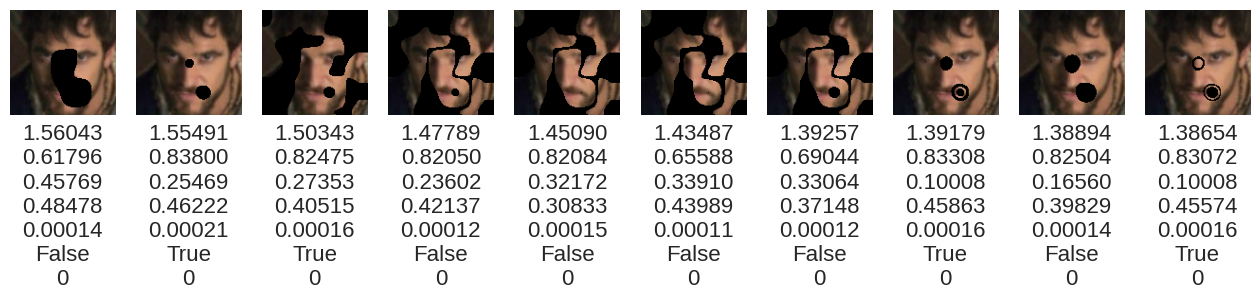

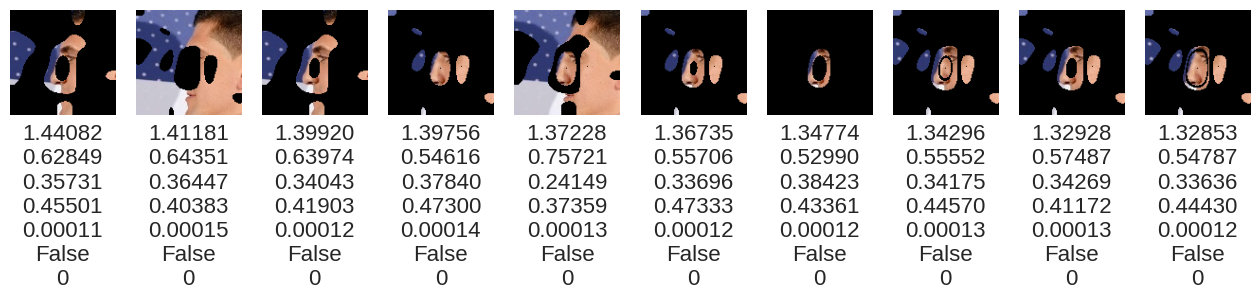

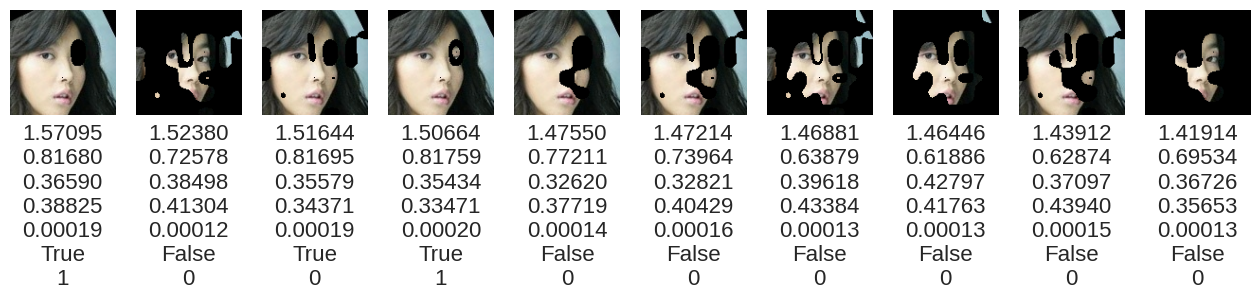

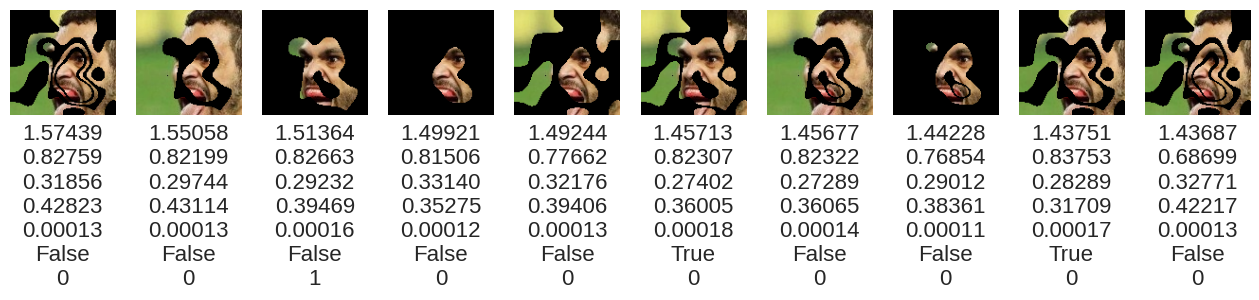

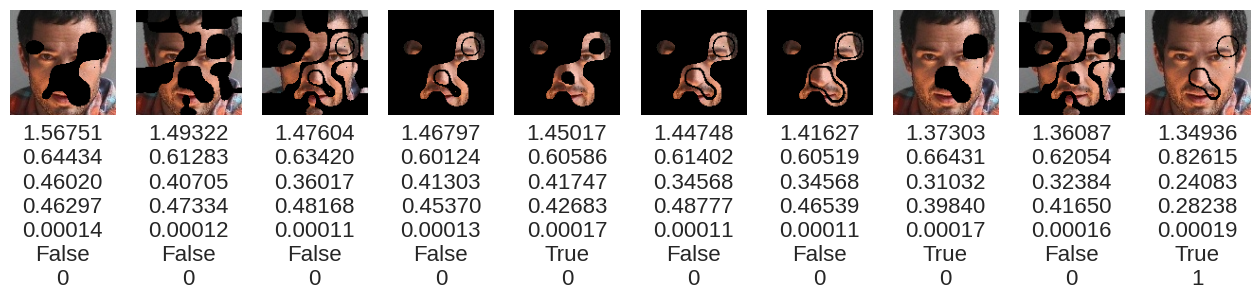

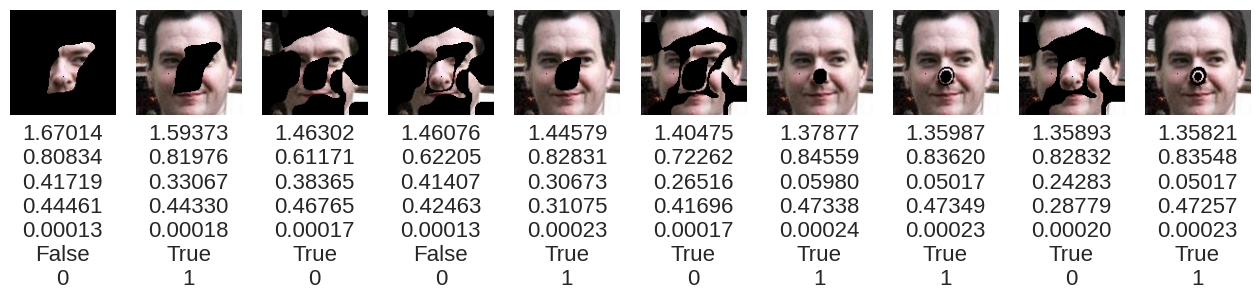

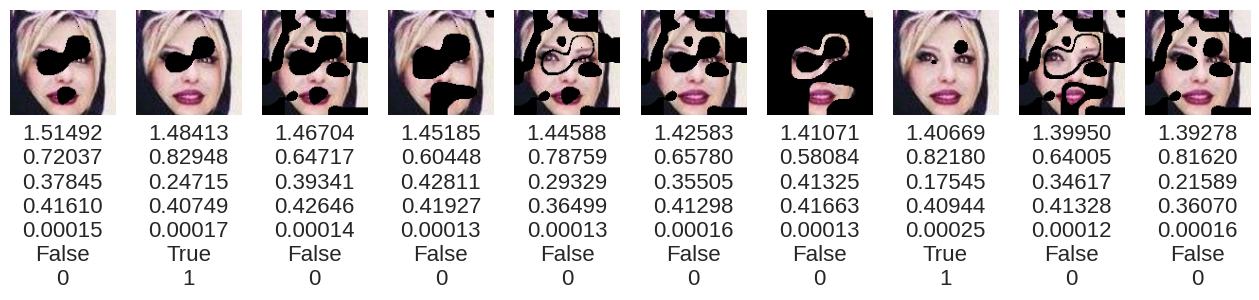

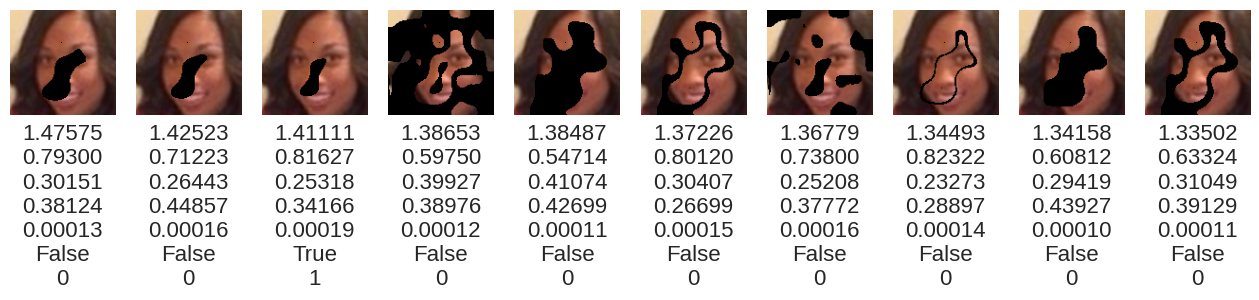

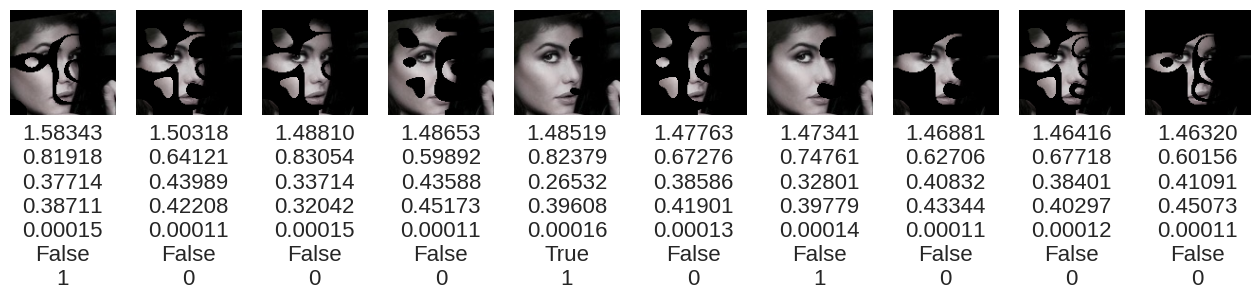

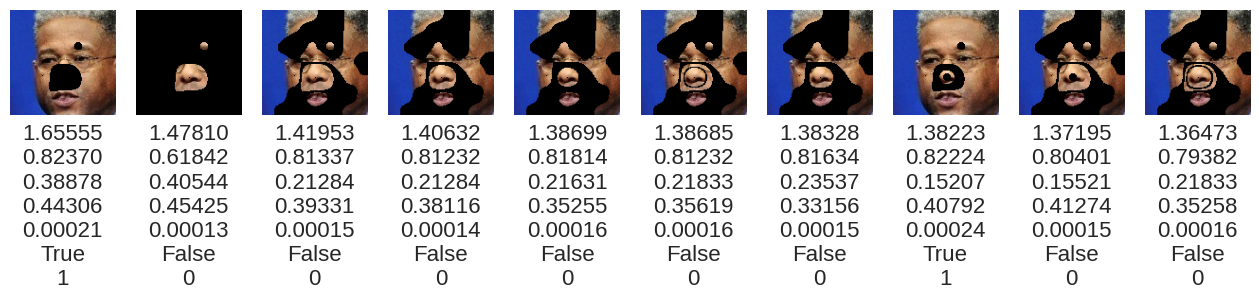

In [13]:
batch_size = 50
topk = 10

for id_person in id_peoples:
    if ".py" in id_person:
        continue

    gt_label = id_person2id[id_person]

    id_person_path = os.path.join(ID_results_path, id_person)

    # load image names
    image_txt = os.path.join(id_person_path, "image.txt")
    with open(image_txt, "r") as f:
        image_names = f.read().split('\n')
        while "" in image_names:
            image_names.remove("")
    # load masks
    explanation_masks = np.load(
        os.path.join(id_person_path, "explanation.npy")
    )
    # Loop image names
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(os.path.join(ID_image_path, id_person), image_name)
        image = cv2.imread(image_path)
        
        mask = norm(explanation_masks[i])[:, :, np.newaxis]

        masked_images = []
        image_list = []

        for erasing_threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            masked_image = image * (mask < erasing_threshold).astype(int) * (mask > erasing_threshold-0.1).astype(int)
            # input_images.append(convert_prepare_image(masked_image.astype(np.uint8)))
            image_list.append(masked_image.astype(np.uint8))
            
        image_list = combination_mask(image_list)
        input_images = [convert_prepare_image(img) for img in image_list]
        smdl_score, u_, r_, mc_, fr_r = smdl(input_images)
        
        predicted_ids = np.argmax(fr_r, axis=1) == gt_label # if face predict model is true
        predicted_score = softmax(fr_r)[:, gt_label]
        
        inds = np.argsort(smdl_score)[-topk:]

        # visualization
        plt.figure(figsize=(16,16))
        for j, ind in enumerate(inds):
            ax = plt.subplot(1, topk, topk-j)
        
            plt.axis('off')
            plt.imshow(Image.fromarray(cv2.cvtColor(image_list[ind], cv2.COLOR_BGR2RGB)))

            # mtcnn_detect
            bx, ldmrk = detect_faces(Image.fromarray(cv2.cvtColor(image_list[ind], cv2.COLOR_BGR2RGB)), thresholds = [0.6, 0.7, 0.85])

            ax.set_title(
                "{:.5f}\n{:.5f}\n{:.5f}\n{:.5f}\n{:.5f}\n{}\n{}".format(
                    smdl_score[ind], u_[ind], r_[ind], mc_[ind], 
                    predicted_score[ind], predicted_ids[ind], len(bx)),
                y=-1.7,
                fontsize=16)
            if j == topk:
                break
        # plt.savefig("results/{}.jpg".format(id_person), bbox_inches='tight')
        break
    break
        

In [12]:
image_list2 = combination_mask(image_list)

# Attribute Submodular

In [1]:
mt = "VGGFace2-all"

if mt == "VGGFace2-all":
    # VGGFace2, all the attribute (40)
    ID_path = [
        'motivation/images/VGGFace2/ID/n000307',
        'motivation/images/VGGFace2/ID/n000309',
        'motivation/images/VGGFace2/ID/n000337',
        'motivation/images/VGGFace2/ID/n000353',
        'motivation/images/VGGFace2/ID/n000359',
        'motivation/images/VGGFace2/ID/n003021',
        'motivation/images/VGGFace2/ID/n003197',
        'motivation/images/VGGFace2/ID/n005546',
        'motivation/images/VGGFace2/ID/n006579',
        'motivation/images/VGGFace2/ID/n006634',
    ]

    model_path = "ckpt/AttributeNet-CelebA-all.onnx"
    
    attribute_set = [
        'blurry', 'sideburns', 'wearing_earrings', 'bald', 'goatee', 'mustache',
        '5_o_clock_shadow', 'arched_eyebrows', 'no_beard', 'heavy_makeup', 'male',
        'wearing_lipstick', 'black_hair', 'high_cheekbones', 'smiling',
        'mouth_slightly_open', 'oval_face', 'bushy_eyebrows', 'attractive',
        'young', 'gray_hair', 'brown_hair', 'blond_hair', 'pale_skin', 'chubby',
        'double_chin', 'big_nose', 'bags_under_eyes', 'wearing_necklace', 'wearing_necktie',
        'rosy_cheeks', 'bangs', 'wavy_hair', 'straight_hair', 'wearing_hat', 'big_lips',
        'narrow_eyes', 'pointy_nose', 'receding_hairline', 'eyeglasses'
    ]

In [6]:
def interpolate(img, size):
    if type(size) == tuple:
        assert size[0] == size[1]
        size = size[0]
    
    orig_size = img.size(3)
    if size < orig_size:
        mode = 'area'
    else:
        mode = 'bilinear'
    return F.interpolate(img, (size, size), mode=mode)

def prepare_image(path):
    img = Image.open(path).convert('RGB')
    img = TF.to_tensor(img)
    img = img.unsqueeze(0)
    if img.size(-1) != 224:
        img = interpolate(img, 224)
    img = img.permute(0, 2, 3, 1)
    return img[0].numpy()

def convert_prepare_image(image, size=224):
    img = Image.fromarray(image)
    img = TF.to_tensor(img)
    img = img.unsqueeze(0)
    if img.size(-1) != 224:
        img = interpolate(img, 224)
    img = img.permute(0, 2, 3, 1)

    return img[0].numpy()

def norm(image):
    """
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    return image

In [7]:
id_person = 'n000307'
Attribute_results_path = "motivation/results/VGGFace2-all/Attribute"
Attribute_image_path = "motivation/images/VGGFace2/ID"

In [ ]:
ID_names = os.listdir(Attribute_results_path)

for id_person in ID_names:
    id_person_path = os.path.join(Attribute_results_path, id_person)
    # Read the json file
    with open(os.path.join(id_person_path, 'Record.json'),'r',encoding = 'utf-8') as fp:
        json_data = json.load(fp)
        
    explanation_masks_save_dir = os.path.join(id_person_path, "explanation")
    explanation_masks_names = os.listdir(explanation_masks_save_dir)
    
    for explanation_masks_name in explanation_masks_names:
        attributes = json_data[explanation_masks_name.replace(".npy", ".jpg")]['attribute']
        
        explanation_masks = np.load(
                os.path.join(explanation_masks_save_dir, explanation_masks_name))
        
        image_path = os.path.join(
                os.path.join(Attribute_image_path, id_person),
                explanation_masks_name.replace(".npy", ".jpg")
            )
        
        for i, attribute in enumerate(attributes):